**sentiment-analysis-for-mental-health/data**

https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/data



In [ ]:
# All packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle
import random

from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import bigrams
from nltk.util import ngrams
import re
import nltk


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, GRU
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import keras_tuner as kt
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, MultiHeadAttention, LayerNormalization, Add
)
from tensorflow.keras.layers import Bidirectional, Reshape
print("Updated NLTK paths:", nltk.data.path)

Updated NLTK paths: ['C:\\Users\\kdolg/nltk_data', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\nltk_data', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\share\\nltk_data', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\lib\\nltk_data', 'C:\\Users\\kdolg\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


# Data Loading & Inspection

In [11]:
# path to the data - ADJUST IF RUNNING IN NEW ENV! =)
file_path = './mh_data/raw_data.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)


df.rename(columns={'Unnamed: 0': 'unique_id'}, inplace = True)

# Display the DataFrame
print(df.head())


   unique_id                                          statement   status
0          0                                         oh my gosh  Anxiety
1          1  trouble sleeping, confused mind, restless hear...  Anxiety
2          2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3          3  I've shifted my focus to something else but I'...  Anxiety
4          4  I'm restless and restless, it's been a month n...  Anxiety


# Evaluate the Balance of Status

Data Shape: Rows = 51795 , Columns = 4

Overall Distribution of 'status':
status
Normal                  15511
Depression              15372
Suicidal                10644
Anxiety                  3829
Bipolar                  2777
Stress                   2585
Personality disorder     1077
Name: count, dtype: int64

Percentages of 'status':
status
Normal                  30.0
Depression              30.0
Suicidal                21.0
Anxiety                  7.0
Bipolar                  5.0
Stress                   5.0
Personality disorder     2.0
Name: count, dtype: float64


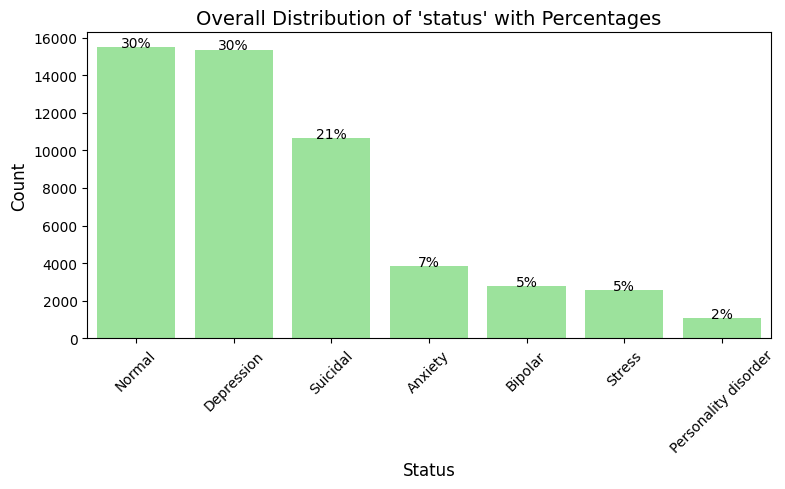

In [12]:
# remove missing statements

df = df[df['statement'].notnull()]

# Add statement length field

df['statement_len'] = df['statement'].apply(lambda x: len(x.split(' ')))

# Remove statements with less than 2 words

df = df[df['statement_len'] > 2].reset_index(drop = True)

# calculate the overall distribution of status and percentages

status_distribution_overall = df['status'].value_counts()
status_percentages = (status_distribution_overall / df.shape[0]) * 100

# print data shape and overall status distribution with percentages
print("Data Shape: Rows =", df.shape[0], ", Columns =", df.shape[1])
print("\nOverall Distribution of 'status':")
print(status_distribution_overall)
print("\nPercentages of 'status':")
print(status_percentages.round())

# plot the overall status distribution with percentages
plt.figure(figsize=(8, 5))
sns.barplot(x=status_distribution_overall.index, y=status_distribution_overall.values, color='lightgreen')

# titles and labels
plt.title("Overall Distribution of 'status' with Percentages", fontsize=14)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)

# put the percentages on the bars
for index, value in enumerate(status_distribution_overall.values):
    percentage = f"{round(status_percentages.values[index]):.0f}%"
    plt.text(index, value + 5, percentage, ha='center', fontsize=10)

plt.tight_layout()

# output
plt.show()


# Performing Text Pre-Processing

In [13]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stopwords (including custom domain-specific stopwords)
all_stopwords = set(stopwords.words('english'))

# Prep statements for models
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Regex
    text = re.sub(
        r'http[s]?://\S+|www\.\S+|\S+\.(com|org|edu|gov|net|io|co)\S*|'
        r'\[.*?\]|<.*?>+|@\w+|\n|\w*\d\w*|[^a-zA-Z\s]', 
        ' ', 
        text
    )
    
    # Lowercase and remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip().lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if len(word) > 2 and word not in all_stopwords]
    
    return tokens

df['processed_text'] = df['statement'].dropna().apply(preprocess_text)

print(df['processed_text'].head())

0                                               [gosh]
1    [trouble, sleeping, confused, mind, restless, ...
2    [wrong, back, dear, forward, doubt, stay, rest...
3    [shifted, focus, something, else, still, worried]
4               [restless, restless, month, boy, mean]
Name: processed_text, dtype: object


# Grouping the status

In [14]:
status_mapping = {
    "Normal": "Normal",
    "Depression": "Depression",
    "Suicidal": "Depression",
    # Any status not explicitly listed will default to "Class 3: Other"
}

# Apply the mapping to the status column
df['grouped_status'] = df['status'].map(status_mapping).fillna("Other")

print(df['grouped_status'].value_counts())



grouped_status
Depression    26016
Normal        15511
Other         10268
Name: count, dtype: int64


# Distribution for new classes

Data Shape: Rows = 51795 , Columns = 6

Overall Distribution of 'new status':
grouped_status
Depression    26016
Normal        15511
Other         10268
Name: count, dtype: int64

Percentages of 'new status':
grouped_status
Depression    50.0
Normal        30.0
Other         20.0
Name: count, dtype: float64


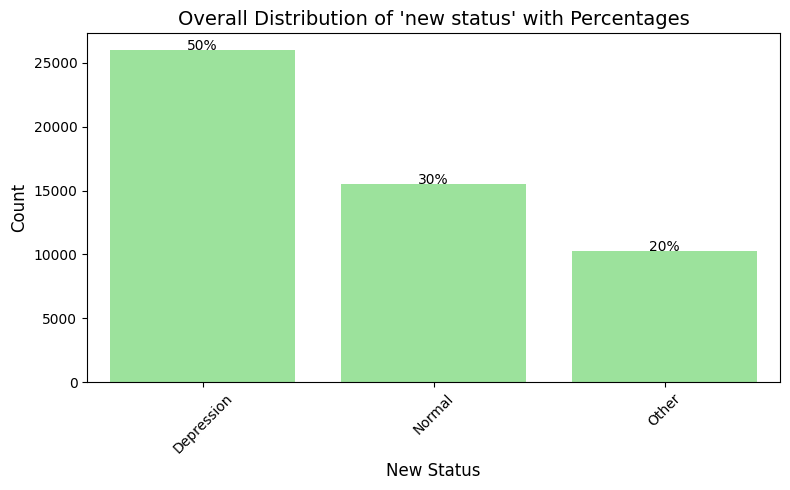

In [15]:
# calculate the overall distribution of status and percentages

status_distribution_overall = df['grouped_status'].value_counts()
status_percentages = (status_distribution_overall / df.shape[0]) * 100

# print data shape and overall status distribution with percentages
print("Data Shape: Rows =", df.shape[0], ", Columns =", df.shape[1])
print("\nOverall Distribution of 'new status':")
print(status_distribution_overall)
print("\nPercentages of 'new status':")
print(status_percentages.round())

# plot the overall status distribution with percentages
plt.figure(figsize=(8, 5))
sns.barplot(x=status_distribution_overall.index, y=status_distribution_overall.values, color='lightgreen')

plt.title("Overall Distribution of 'new status' with Percentages", fontsize=14)
plt.xlabel("New Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)

# put the percentages on the bars
for index, value in enumerate(status_distribution_overall.values):
    percentage = f"{round(status_percentages.values[index]):.0f}%"
    plt.text(index, value + 5, percentage, ha='center', fontsize=10)

plt.tight_layout()

# output
plt.show()


# Train-Test Splits, SMOTE and Bag-of-Words

In [9]:
# Remove rows with NaN in 'statement' or 'grouped_status'
df = df.dropna(subset=['statement', 'grouped_status'])

# Define features and labels
X = df['statement']
y = df['grouped_status']

# Train-test-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Bag of Words text representation
vectorizer = CountVectorizer(max_features=10000)
X_train_bow = vectorizer.fit_transform(X_train)
X_val_bow = vectorizer.transform(X_val)
X_test_bow = vectorizer.transform(X_test)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_bow, y_train)

# Print distributions for sanity check
print("Balanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())


Balanced class distribution:
grouped_status
Depression    16650
Other         16650
Normal        16650
Name: count, dtype: int64


# BASELINE Model Build - Bag of Words with Multiclass Logistic Regression

In [16]:
# Logistic Regression Classifier
lr_model = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs", random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)

# Validation Performance
y_val_pred = lr_model.predict(X_val_bow)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (Logistic Regression): {val_accuracy:.2f}")

# Test Performance
y_test_pred = lr_model.predict(X_test_bow)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (Logistic Regression): {test_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_test_pred))

C:\Users\kdolg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (Logistic Regression): 0.89
Test Accuracy (Logistic Regression): 0.90

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  Depression       0.94      0.90      0.92      5203
      Normal       0.90      0.93      0.92      3102
       Other       0.78      0.83      0.81      2054

    accuracy                           0.90     10359
   macro avg       0.88      0.89      0.88     10359
weighted avg       0.90      0.90      0.90     10359



# Changing Class Balance Model to Address Class 2 Issues

In [61]:
# Compute new class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.6636236236236236, 1: 1.1130586615627414, 2: 1.681529954852128}


# BASELINE Model Build - Bag of Words with Multiclass Logistic Regression With New Class Weighting

In [ ]:
# Remove rows with NaN in 'statement' or 'grouped_status'
df = df.dropna(subset=['statement', 'grouped_status'])

# Define features and labels
X = df['statement']
y = df['grouped_status']

# Encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Bag of Words text representation
vectorizer = CountVectorizer(max_features=10000)
X_train_bow = vectorizer.fit_transform(X_train)
X_val_bow = vectorizer.transform(X_val)
X_test_bow = vectorizer.transform(X_test)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
print("Class Weights:", class_weights_dict)

# Logistic Regression Classifier with class weights
lr_model = LogisticRegression(
    max_iter=1000, 
    multi_class="multinomial", 
    solver="lbfgs", 
    random_state=42, 
    class_weight=class_weights_dict
)
lr_model.fit(X_train_bow, y_train)

# Validation Performance
y_val_pred = lr_model.predict(X_val_bow)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (Logistic Regression): {val_accuracy:.2f}")

# Test Performance
y_test_pred = lr_model.predict(X_test_bow)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (Logistic Regression): {test_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Logistic Regression):")
print(classification_report(
    label_encoder.inverse_transform(y_test), 
    label_encoder.inverse_transform(y_test_pred), 
    target_names=label_encoder.classes_
))


Class Weights: {0: 0.6636236236236236, 1: 1.1130586615627414, 2: 1.681529954852128}


C:\Users\kdolg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (Logistic Regression): 0.90
Test Accuracy (Logistic Regression): 0.90

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  Depression       0.95      0.90      0.92      5203
      Normal       0.89      0.95      0.92      3102
       Other       0.82      0.83      0.82      2054

    accuracy                           0.90     10359
   macro avg       0.88      0.89      0.89     10359
weighted avg       0.90      0.90      0.90     10359



# LSTM Model with class weighting and hyperparameter tuning

In [ ]:

max_vocab_size = 10000
max_sequence_length = 100

vectorizer_lstm_weight = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode="int",
    output_sequence_length=max_sequence_length
)

# Adapt the TextVectorization layer to the training data
vectorizer_lstm_weight.adapt(X_train)

# Vectorize the datasets
X_train_vectorized = vectorizer_lstm_weight(X_train).numpy()
X_val_vectorized = vectorizer_lstm_weight(X_val).numpy()
X_test_vectorized = vectorizer_lstm_weight(X_test).numpy()

# Encode Labels
label_encoder_lstm_weight = LabelEncoder()
y_train_encoded = label_encoder_lstm_weight.fit_transform(y_train)
y_val_encoded = label_encoder_lstm_weight.transform(y_val)
y_test_encoded = label_encoder_lstm_weight.transform(y_test)

num_classes = len(label_encoder_lstm_weight.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train_encoded), 
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.6636236236236236, 1: 1.1130586615627414, 2: 1.681529954852128}


In [ ]:
# LSTM Function

def build_model_lstm_weight(hp, max_vocab_size=10000, max_sequence_length=100):
    model_lstm_weight = Sequential([
        Embedding(
            input_dim=max_vocab_size,
            output_dim=hp.Int("embedding_dim", min_value=50, max_value=300, step=50),
            input_length=max_sequence_length,
            trainable=True
        ),
        LSTM(
            hp.Int("lstm_units_1", min_value=64, max_value=256, step=64),
            return_sequences=True,
            dropout=hp.Float("dropout_1", min_value=0.1, max_value=0.5, step=0.1),
            recurrent_dropout=0.2
        ),
        LSTM(
            hp.Int("lstm_units_2", min_value=32, max_value=128, step=32),
            return_sequences=False,
            dropout=hp.Float("dropout_2", min_value=0.2, max_value=0.5, step=0.1),
            recurrent_dropout=0.2
        ),
        Dense(
            hp.Int("dense_units", min_value=32, max_value=128, step=32),
            activation="relu"
        ),
        Dropout(hp.Float("dropout_dense", min_value=0.2, max_value=0.5, step=0.1)),
        Dense(num_classes, activation="softmax")
    ])

    # Compile the model with tunable learning rate
    model_lstm_weight.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[1e-4, 5e-4, 1e-3])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model_lstm_weight


# Initialize the tuner
tuner = kt.BayesianOptimization(
    build_model_lstm_weight,
    objective="val_accuracy",
    max_trials=50,
    directory="hyperparameter_tuning",
    project_name="lstm_weight_tuning"
)

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor="val_accuracy", 
    patience=3,              
    restore_best_weights=True
)

# Perform hyperparameter search
tuner.search(
    X_train_vectorized, y_train_categorical,
    validation_data=(X_val_vectorized, y_val_categorical),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps_lstm_weight = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps_lstm_weight.values)

# Train the model with the best hyperparameters
model_lstm_weight = tuner.hypermodel.build(best_hps_lstm_weight)
history = model_lstm_weight.fit(
    X_train_vectorized, y_train_categorical,
    validation_data=(X_val_vectorized, y_val_categorical),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_lstm_weight.evaluate(X_test_vectorized, y_test_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Trial 50 Complete [00h 06m 42s]
val_accuracy: 0.9096283912658691

Best val_accuracy So Far: 0.9196428656578064
Total elapsed time: 10h 15m 41s
Best Hyperparameters:
{'embedding_dim': 200, 'lstm_units_1': 256, 'dropout_1': 0.1, 'lstm_units_2': 128, 'dropout_2': 0.2, 'dense_units': 32, 'dropout_dense': 0.2, 'learning_rate': 0.001}
Epoch 1/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 141s 133ms/step - accuracy: 0.5438 - loss: 0.8520 - val_accuracy: 0.7062 - val_loss: 0.6602
Epoch 2/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 137s 132ms/step - accuracy: 0.7051 - loss: 0.6273 - val_accuracy: 0.8295 - val_loss: 0.4509
Epoch 3/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 137s 132ms/step - accuracy: 0.8433 - loss: 0.4125 - val_accuracy: 0.8694 - val_loss: 0.3738
Epoch 4/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 136s 131ms/step - accuracy: 0.8896 - loss: 0.3145 - val_accuracy: 0.9006 - val_loss: 0.2885
Epoch 5/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 135s 131ms/step - accuracy: 0.9265 - loss: 0.2210 - val_accuracy: 0.9023 - val_loss: 0.2820

In [ ]:
# Save the model and components
save_dir = "models/lstm_weight_model_tuned"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model with the `.keras` extension (recommended for the latest TensorFlow/Keras)
model_lstm_weight.save(os.path.join(save_dir, "model_lstm_weight.keras"))

# Save the vectorizer configuration
vectorizer_lstm_weight_config = vectorizer_lstm_weight.get_config()
vectorizer_lstm_weight_vocabulary = vectorizer_lstm_weight.get_vocabulary()

vectorizer_lstm_weight_path = os.path.join(save_dir, "vectorizer_lstm_weight.pkl")
with open(vectorizer_lstm_weight_path, "wb") as f:
    pickle.dump({
        "config": vectorizer_lstm_weight_config,
        "vocabulary": vectorizer_lstm_weight_vocabulary
    }, f)

# Save the label encoder
label_encoder_lstm_weight_path = os.path.join(save_dir, "label_encoder_lstm_weight.pkl")
with open(label_encoder_lstm_weight_path, "wb") as f:
    pickle.dump(label_encoder_lstm_weight, f)

print(f"LSTM model, vectorizer, and label encoder saved to {save_dir}")


In [ ]:
# Define the save directory
save_dir = "models/lstm_weight_model_tuned"

# Load the model
model_lstm_weight = load_model(os.path.join(save_dir, "model_lstm_weight.keras"))

# Load the vectorizer
vectorizer_lstm_weight_path = os.path.join(save_dir, "vectorizer_lstm_weight.pkl")
with open(vectorizer_lstm_weight_path, "rb") as f:
    vectorizer_data = pickle.load(f)

# Recreate the TextVectorization layer
vectorizer_lstm_weight = TextVectorization.from_config(vectorizer_data["config"])
vectorizer_lstm_weight.set_vocabulary(vectorizer_data["vocabulary"])

# Load the label encoder
label_encoder_lstm_weight_path = os.path.join(save_dir, "label_encoder_lstm_weight.pkl")
with open(label_encoder_lstm_weight_path, "rb") as f:
    label_encoder_lstm_weight = pickle.load(f)

print("Model, vectorizer, and label encoder loaded successfully.")


Model, vectorizer, and label encoder loaded successfully.


In [ ]:
# Classification Report
y_test_pred_lstm_weight = model_lstm_weight.predict(X_test_vectorized)
y_test_pred_lstm_weight_classes = np.argmax(y_test_pred_lstm_weight, axis=1)
y_test_true_lstm_weight_classes = np.argmax(y_test_categorical, axis=1)

print("\nClassification Report LSTM Embedding:")
print(classification_report(y_test_true_lstm_weight_classes, y_test_pred_lstm_weight_classes))


324/324 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step

Classification Report LSTM Embedding:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      5203
           1       0.94      0.90      0.92      3102
           2       0.80      0.90      0.85      2054

    accuracy                           0.91     10359
   macro avg       0.90      0.91      0.90     10359
weighted avg       0.92      0.91      0.91     10359



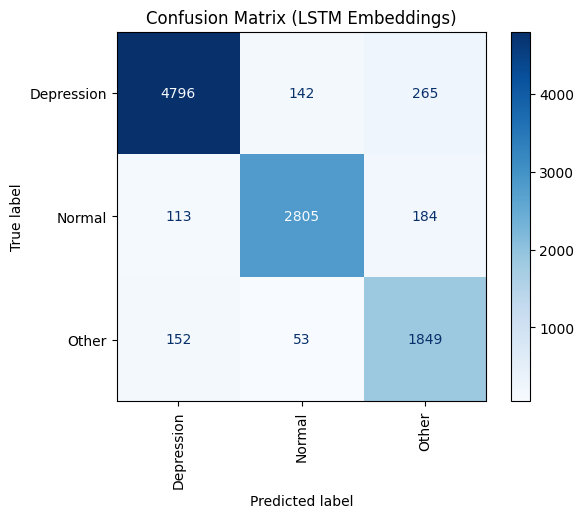

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_true_lstm_weight_classes, y_test_pred_lstm_weight_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder_lstm_weight.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix (LSTM Embeddings)")
plt.show()

# Transformer Model- TinyBERT 10 Epochs with SoftMax ----> DONT NEED TO INCLUDE

In [ ]:
# Set random seeds for reproducibility
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Encode Labels
label_encoder_tinybert = LabelEncoder()
y_train_encoded = label_encoder_tinybert.fit_transform(y_train)
y_val_encoded = label_encoder_tinybert.transform(y_val)
y_test_encoded = label_encoder_tinybert.transform(y_test)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

# Load TinyBERT tokenizer and model
model_name = "prajjwal1/bert-tiny"
tokenizer_tinybert = AutoTokenizer.from_pretrained(model_name)
model_tinybert = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, from_pt=True)

# Tokenize the data
def tokenize_data(texts, labels, tokenizer, max_length=64):
    tokenized_texts = tokenizer(
        list(texts),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="tf"
    )
    return {
        "input_ids": tokenized_texts["input_ids"],
        "attention_mask": tokenized_texts["attention_mask"],
        "labels": tf.convert_to_tensor(labels)
    }

train_data = tokenize_data(X_train, y_train_encoded, tokenizer_tinybert)
val_data = tokenize_data(X_val, y_val_encoded, tokenizer_tinybert)
test_data = tokenize_data(X_test, y_test_encoded, tokenizer_tinybert)

# Prepare datasets
batch_size = 16

def create_tf_dataset(data):
    return tf.data.Dataset.from_tensor_slices(({
        "input_ids": data["input_ids"],
        "attention_mask": data["attention_mask"]
    }, tf.one_hot(data["labels"], depth=3))).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_tf_dataset(train_data)
val_dataset = create_tf_dataset(val_data)

# Define optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy()

# Custom Training Loop with Class Weights
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training
    for batch, (inputs, labels) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            outputs = model_tinybert(inputs, training=True)
            class_weights_tensor = tf.constant([class_weights_dict[i] for i in range(len(class_weights_dict))], dtype=tf.float32)
            sample_weights = tf.reduce_sum(class_weights_tensor * labels, axis=1)
            loss = tf.reduce_mean(loss_fn(labels, outputs.logits) * sample_weights)
        gradients = tape.gradient(loss, model_tinybert.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_tinybert.trainable_variables))
        metric.update_state(labels, outputs.logits)

        if batch % 100 == 0:
            print(f"Step {batch}: Loss = {loss.numpy()}, Accuracy = {metric.result().numpy()}")

    # Validation
    val_loss = 0
    val_metric = tf.keras.metrics.CategoricalAccuracy()
    for val_inputs, val_labels in val_dataset:
        val_outputs = model_tinybert(val_inputs, training=False)
        val_loss += loss_fn(val_labels, val_outputs.logits)
        val_metric.update_state(val_labels, val_outputs.logits)

    print(f"Validation Loss: {val_loss / len(val_dataset)}, Validation Accuracy: {val_metric.result().numpy()}")

# Evaluate on the Test Set
test_dataset = create_tf_dataset(test_data)
test_predictions_tinybert = []
test_true_tinybert = []

for test_inputs, test_labels in test_dataset:
    test_outputs = model_tinybert(test_inputs, training=False)
    test_predictions_tinybert.extend(tf.argmax(test_outputs.logits, axis=1).numpy())
    test_true_tinybert.extend(tf.argmax(test_labels, axis=1).numpy())

# Generate Classification Report
print(classification_report(test_true_tinybert, test_predictions_tinybert, target_names=label_encoder_tinybert.classes_))

# Save Model, Tokenizer, and Label Encoder
save_dir = "tinybert_model"
os.makedirs(save_dir, exist_ok=True)

# Save the model
model_tinybert.save_pretrained(save_dir)

# Save the tokenizer
tokenizer_tinybert.save_pretrained(save_dir)

# Save the label encoder
with open(os.path.join(save_dir, "label_encoder_tinybert.pkl"), "wb") as le_file:
    pickle.dump(label_encoder_tinybert, le_file)

print(f"TinyBERT model, tokenizer, and label encoder saved to {save_dir}")


Class Weights: {0: 0.6636236236236236, 1: 1.1130586615627414, 2: 1.681529954852128}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Step 0: Loss = 1.133665919303894, Accuracy = 0.4375
Step 100: Loss = 0.7491054534912109, Accuracy = 0.5179455280303955
Step 200: Loss = 0.7437362670898438, Accuracy = 0.59732586145401
Step 300: Loss = 0.49791231751441956, Accuracy = 0.6650747656822205
Step 400: Loss = 0.6307628750801086, Accuracy = 0.6996570825576782
Step 500: Loss = 0.7767693400382996, Accuracy = 0.7262973785400391
Step 600: Loss = 0.3253135681152344, Accuracy = 0.7453203201293945
Step 700: Loss = 0.5749486684799194, Accuracy = 0.7560627460479736
Step 800: Loss = 0.8099021315574646, Accuracy = 0.7654494643211365
Step 900: Loss = 0.5236510038375854, Accuracy = 0.773515522480011
Step 1000: Loss = 0.5700181722640991, Accuracy = 0.7812187671661377
Step 1100: Loss = 0.3164534568786621, Accuracy = 0.787976861000061
Step 1200: Loss = 0.9833024740219116, Accuracy = 0.795326828956604
Step 1300: Loss = 0.8724329471588135, Accuracy = 0.8006821870803833
Step 1400: Loss = 0.4746056795120239, Accuracy = 0.804916143417358

# TinyBERT Load

In [ ]:
# Set random seeds for reproducibility
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load the saved TinyBERT model, tokenizer, and label encoder
save_dir = "tinybert_model"
model_tinybert = TFAutoModelForSequenceClassification.from_pretrained(save_dir)
tokenizer_tinybert = AutoTokenizer.from_pretrained(save_dir)

with open(os.path.join(save_dir, "label_encoder_tinybert.pkl"), "rb") as le_file:
    label_encoder_tinybert = pickle.load(le_file)

print("TinyBERT model, tokenizer, and label encoder successfully loaded.")

# Tokenize the test data
def tokenize_data(texts, tokenizer, max_length=64):
    tokenized_texts = tokenizer(
        list(texts),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="tf"
    )
    return {
        "input_ids": tokenized_texts["input_ids"],
        "attention_mask": tokenized_texts["attention_mask"]
    }

test_data = tokenize_data(X_test, tokenizer_tinybert)

# Prepare test dataset
batch_size = 16

def create_tf_dataset(data):
    return tf.data.Dataset.from_tensor_slices({
        "input_ids": data["input_ids"],
        "attention_mask": data["attention_mask"]
    }).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = create_tf_dataset(test_data)

# Predict and collect results
test_predictions_tinybert = []
test_true_tinybert = y_test_encoded

for test_inputs in test_dataset:
    test_outputs = model_tinybert(test_inputs, training=False)
    test_predictions_tinybert.extend(tf.argmax(test_outputs.logits, axis=1).numpy())

# Convert to numpy arrays
test_predictions_tinybert = np.array(test_predictions_tinybert)
test_true_tinybert = np.array(test_true_tinybert)

Some layers from the model checkpoint at tinybert_model were not used when initializing TFBertForSequenceClassification: ['dropout_57']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at tinybert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
C:\Users\kdolg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2

TinyBERT model, tokenizer, and label encoder successfully loaded.


In [ ]:
# Generate Classification Report
print("\nClassification Report:")
print(classification_report(test_true_tinybert, test_predictions_tinybert, target_names=label_encoder_tinybert.classes_))



Classification Report:
              precision    recall  f1-score   support

  Depression       0.95      0.93      0.94      5203
      Normal       0.93      0.93      0.93      3102
       Other       0.83      0.88      0.85      2054

    accuracy                           0.92     10359
   macro avg       0.90      0.91      0.91     10359
weighted avg       0.92      0.92      0.92     10359



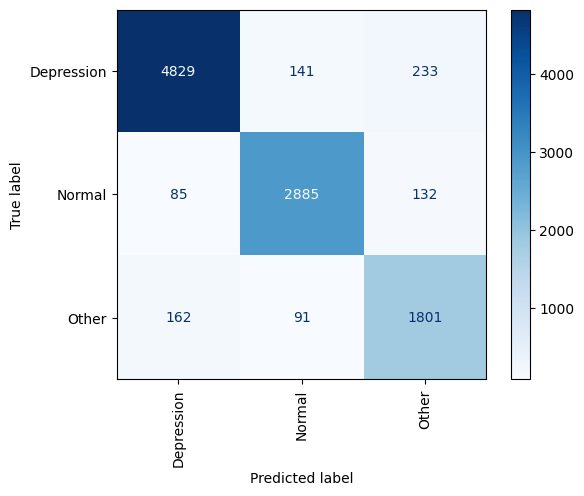

In [59]:
# Generate and Display Confusion Matrix
conf_matrix = confusion_matrix(test_true_tinybert, test_predictions_tinybert)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder_tinybert.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

# Transformer Embedding with a Bidirectional LSTM

In [ ]:
# Set seeds for repeatability
def set_seeds(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Load DistilBERT tokenizer and model
distilbert_model_name = "distilbert-base-uncased"
tokenizer_distilbert_lstm_weight = DistilBertTokenizer.from_pretrained(distilbert_model_name)
distilbert_model = TFDistilBertModel.from_pretrained(distilbert_model_name)

def generate_distilbert_embeddings_batched(texts, batch_size=256, max_length=100):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer_distilbert_lstm_weight(
            batch_texts.tolist(),
            return_tensors="tf",
            padding="max_length",
            truncation=True,
            max_length=max_length
        )
        outputs = distilbert_model(inputs["input_ids"], attention_mask=inputs["attention_mask"])
        embeddings.append(outputs.last_hidden_state)
    return tf.concat(embeddings, axis=0)

X_train_sample = X_train[:20000]
X_train_embeddings = generate_distilbert_embeddings_batched(X_train_sample, batch_size=256)
y_train_sample = y_train[:20000]

# Generate embeddings for datasets
X_val_embeddings = generate_distilbert_embeddings_batched(X_val)
X_test_embeddings = generate_distilbert_embeddings_batched(X_test)

# Encode Labels
label_encoder_distilbert_lstm_weight = LabelEncoder()
y_train_encoded = label_encoder_distilbert_lstm_weight.fit_transform(y_train_sample)
y_val_encoded = label_encoder_distilbert_lstm_weight.transform(y_val)
y_test_encoded = label_encoder_distilbert_lstm_weight.transform(y_test)

num_classes = len(label_encoder_distilbert_lstm_weight.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Class Weights: {0: 0.6614412805503191, 1: 1.1124089215195505, 2: 1.6972165648336728}


# Transformer Embedding with a Bidirectional LSTM

In [ ]:
# Set seeds for repeatability
def set_seeds(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Define the model with Bidirectional LSTM layer
def build_model_distilbert_bidirectional_lstm(hp):
    inputs = Input(shape=(X_train_embeddings.shape[1], X_train_embeddings.shape[2]))

    # Multi-head attention
    attn_output = MultiHeadAttention(
        num_heads=hp.Choice("num_heads", values=[4, 8]),
        key_dim=hp.Choice("key_dim", values=[64])
    )(inputs, inputs)
    attn_output = Add()([inputs, attn_output])
    attn_output = LayerNormalization()(attn_output)

    # Bidirectional LSTM layer
    x = Bidirectional(
        LSTM(hp.Int("lstm_units", min_value=64, max_value=256, step=64), dropout=0.3, return_sequences=False)
    )(attn_output)

    # Fully connected layers
    x = Dense(hp.Choice("dense_units", values=[64, 128]), activation="relu")(x)
    x = Dropout(hp.Float("dropout_dense", min_value=0.3, max_value=0.5, step=0.1))(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1e-4, 5e-4])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# Early stopping
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

# Initialize the tuner
tuner = kt.BayesianOptimization(
    build_model_distilbert_bidirectional_lstm,
    objective="val_accuracy",
    max_trials=48,
    directory="hyperparameter_tuning",
    project_name="distilbert_bidirectional_lstm"
)

# Perform hyperparameter tuning
tuner.search(
    X_train_embeddings, y_train_categorical,
    validation_data=(X_val_embeddings, y_val_categorical),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping]
)

# Train the model with best hyperparameters
best_hps_distilbert_bidirectional_lstm = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps_distilbert_bidirectional_lstm.values)

best_model_distilbert_bidirectional_lstm = tuner.hypermodel.build(best_hps_distilbert_bidirectional_lstm)
history = best_model_distilbert_bidirectional_lstm.fit(
    X_train_embeddings, y_train_categorical,
    validation_data=(X_val_embeddings, y_val_categorical),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Evaluate on the test set
test_loss, test_accuracy = best_model_distilbert_bidirectional_lstm.evaluate(X_test_embeddings, y_test_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Trial 48 Complete [00h 27m 48s]
val_accuracy: 0.9219353199005127

Best val_accuracy So Far: 0.9280887842178345
Total elapsed time: 1d 02h 11m 09s
Best Hyperparameters: {'num_heads': 4, 'key_dim': 64, 'lstm_units': 128, 'dense_units': 64, 'dropout_dense': 0.4, 'learning_rate': 0.0001}
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 130ms/step - accuracy: 0.7342 - loss: 0.6198 - val_accuracy: 0.8874 - val_loss: 0.3107
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.8871 - loss: 0.3174 - val_accuracy: 0.8990 - val_loss: 0.2865
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.9042 - loss: 0.2648 - val_accuracy: 0.9091 - val_loss: 0.2523
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 129ms/step - accuracy: 0.9143 - loss: 0.2356 - val_accuracy: 0.9118 - val_loss: 0.2515
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.9260 - loss: 0.2084 - val_accuracy: 0.9155 - val_loss: 0.2439
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - acc

In [ ]:
# Define the save directory
save_dir = "distilbert_lstm_best_model"
os.makedirs(save_dir, exist_ok=True)

# Save the fine-tuned best model
best_model_distilbert_bidirectional_lstm.save(os.path.join(save_dir, "best_model.keras"))

# Save the tokenizer
tokenizer_distilbert_lstm_weight.save_pretrained(save_dir)

# Save the label encoder
label_encoder_distilbert_lstm_weight_path = os.path.join(save_dir, "label_encoder_distilbert_lstm_weight.pkl")
with open(label_encoder_distilbert_lstm_weight_path, "wb") as le_file:
    pickle.dump(label_encoder_distilbert_lstm_weight, le_file)

# Save the best hyperparameters
best_hps_path = os.path.join(save_dir, "best_hyperparameters.pkl")
with open(best_hps_path, "wb") as hp_file:
    pickle.dump(best_hps_distilbert_bidirectional_lstm.values, hp_file)

print(f"Best model, tokenizer, label encoder, and hyperparameters saved to {save_dir}")


Best model, tokenizer, label encoder, and hyperparameters saved to distilbert_lstm_best_model


In [26]:
# Classification Report
y_test_pred_db_lstm = best_model_distilbert_bidirectional_lstm.predict(X_test_embeddings)
y_test_pred_db_lstm_classes = np.argmax(y_test_pred, axis=1)
y_test_true_db_lstm_classes = np.argmax(y_test_categorical, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_true_db_lstm_classes, y_test_pred_db_lstm_classes))

324/324 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      5203
           1       0.92      0.94      0.93      3102
           2       0.86      0.89      0.87      2054

    accuracy                           0.93     10359
   macro avg       0.91      0.92      0.92     10359
weighted avg       0.93      0.93      0.93     10359



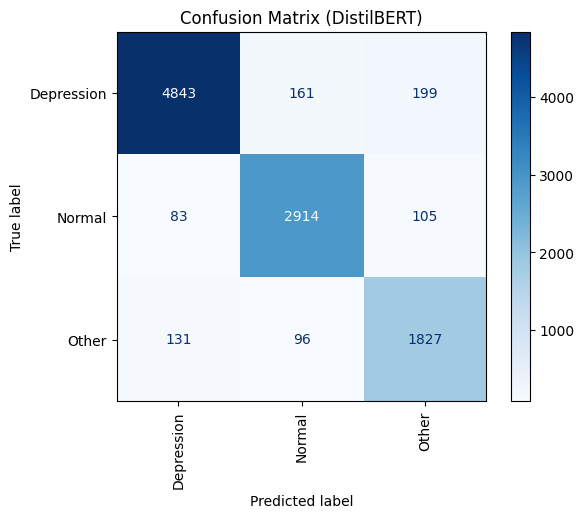

In [75]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_true_db_lstm_classes, y_test_pred_db_lstm_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder_distilbert_lstm_weight.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix (DistilBERT)")
plt.show()

In [ ]:
# Define the save directory
save_dir = "distilbert_lstm_best_model"

# Load the Keras model
best_model = load_model(os.path.join(save_dir, "best_model.keras"))

# Load the tokenizer
tokenizer_distilbert_lstm_weight = DistilBertTokenizer.from_pretrained(save_dir)

# Load the label encoder
label_encoder_distilbert_lstm_weight_path = os.path.join(save_dir, "label_encoder_distilbert_lstm_weight.pkl")
with open(label_encoder_distilbert_lstm_weight_path, "rb") as le_file:
    label_encoder_distilbert_lstm_weight = pickle.load(le_file)

print("Model, tokenizer, and label encoder loaded successfully.")


Model, tokenizer, and label encoder loaded successfully.


In [ ]:
# Define the save directory
save_dir = "distilbert_lstm_best_model"

# Load the best model
best_model = load_model(os.path.join(save_dir, "best_model.keras"))

# Load the tokenizer
tokenizer_distilbert_lstm_weight = DistilBertTokenizer.from_pretrained(save_dir)

# Load the label encoder
label_encoder_distilbert_lstm_weight_path = os.path.join(save_dir, "label_encoder_distilbert_lstm_weight.pkl")
with open(label_encoder_distilbert_lstm_weight_path, "rb") as le_file:
    label_encoder_distilbert_lstm_weight = pickle.load(le_file)

# Load the best hyperparameters
best_hps_path = os.path.join(save_dir, "best_hyperparameters.pkl")
with open(best_hps_path, "rb") as hp_file:
    best_hyperparameters = pickle.load(hp_file)

print("Best model, tokenizer, label encoder, and hyperparameters loaded successfully.")
print("Best Hyperparameters:", best_hyperparameters)


Best model, tokenizer, label encoder, and hyperparameters loaded successfully.
Best Hyperparameters: {'num_heads': 4, 'key_dim': 64, 'lstm_units': 128, 'dense_units': 64, 'dropout_dense': 0.4, 'learning_rate': 0.0001}
